# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다.

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [ ]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
from tqdm import tqdm

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [ ]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
base_path = '../'

train_path = base_path + 'train.csv'
test_path  = base_path + 'test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', df_train.shape, 'Test data shape : ', df_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [ ]:
# Train과 Test data를 살펴보겠습니다.
display(df_train.head(1))
display(df_test.head(1))       # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [ ]:
df_train.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [ ]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
df_train['is_test'] = 0
df_test['is_test'] = 1
df_concat = pd.concat([df_train, df_test])     # 하나의 데이터로 만들어줍니다.

df_concat['is_test'].value_counts()    # 하나의 데이터로 만들어줍니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [ ]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
df_concat = df_concat.rename(columns={'전용면적(㎡)':'전용면적'})
df_concat = df_concat.rename(columns={'k-전용면적별세대현황(60㎡이하)':'k-전용면적별세대_60'})
df_concat = df_concat.rename(columns={'k-전용면적별세대현황(60㎡~85㎡이하)':'k-전용면적별세대_60_85'})
df_concat = df_concat.rename(columns={'k-85㎡~135㎡이하':'k-전용면적별세대_85_135'})
df_concat = df_concat.rename(columns={'k-135㎡초과':'k-전용면적별세대_135'})
df_concat = df_concat.rename(columns={'k-단지분류(아파트,주상복합등등)':'k-단지분류'})
df_concat = df_concat.rename(columns={'k-세대타입(분양형태)':'k-분양형태'})
df_concat = df_concat.rename(columns={'k-건설사(시공사)':'k-시공사'})
df_concat = df_concat.rename(columns={'기타/의무/임대/임의=1/2/3/4':'기타/의무/임대/임의'})
df_concat = df_concat.rename(columns={'관리비 업로드':'관리비업로드'})

# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
# .astype(str)을 수행할 시 np.nan이 문자열 'nan'으로 대체되기 때문데 결측치로 인식되지 않는 문제 발생
df_concat['본번'] = df_concat['본번'].astype(object)
df_concat['부번'] = df_concat['부번'].astype(object)

# 필요 없는 컬럼 제거
df_concat = df_concat.drop(['k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-홈페이지',
                            '고용보험관리번호', '중개사소재지', 'k-수정일자', 'k-등록일자',
                            '해제사유발생일', '등기신청일자', 'k-사용검사일-사용승인일', '단지신청일', '단지승인일',
                            ], axis=1)

display(df_concat.head(1))
display(df_concat.tail(1))

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의,사용허가여부,관리비업로드,좌표X,좌표Y,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,124000.0,0


,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의,사용허가여부,관리비업로드,좌표X,좌표Y,target,is_test
9271,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202309,4,13,2014,...,위탁,14171.0,1568.0,의무,Y,N,127.10672,37.61887,NaN,1


In [ ]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 40 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   시군구               1128094 non-null  object 
 1   번지                1127867 non-null  object 
 2   본번                1128019 non-null  object 
 3   부번                1128019 non-null  object 
 4   아파트명              1125958 non-null  object 
 5   전용면적              1128094 non-null  float64
 6   계약년월              1128094 non-null  int64  
 7   계약일               1128094 non-null  int64  
 8   층                 1128094 non-null  int64  
 9   건축년도              1128094 non-null  int64  
 10  도로명               1128094 non-null  object 
 11  거래유형              1128094 non-null  object 
 12  k-단지분류            250821 non-null   object 
 13  k-분양형태            251969 non-null   object 
 14  k-관리방식            251969 non-null   object 
 15  k-복도유형            251640 non-null   object 
 16  k-난

### EDA

#### 변수 분포 확인

In [ ]:
df_train = df_concat.query('is_test == 0').drop('is_test', axis=1)
num_cols = df_concat.select_dtypes(include=['number']).columns.difference(['target', 'is_test'])
num_cols

# 히스토그램으로 각 변수의 분포 확인
# fig, axes = plt.subplots(6, 3, figsize=(20, 30))
# for i, col in enumerate(num_cols):
#     sns.histplot(df_train[col], ax=axes[i//3, i%3], kde=True)
#     axes[i//3, i%3].set_title(col)

# plt.tight_layout()
# plt.show()

Index(['k-관리비부과면적', 'k-연면적', 'k-전용면적별세대_135', 'k-전용면적별세대_60',
       'k-전용면적별세대_60_85', 'k-전용면적별세대_85_135', 'k-전체동수', 'k-전체세대수', 'k-주거전용면적',
       '건축년도', '건축면적', '계약년월', '계약일', '전용면적', '좌표X', '좌표Y', '주차대수', '층'],
      dtype='object')

In [ ]:
# 0의 개수가 10000개 이상인 열 선택
zero_counts = (df_train[num_cols] == 0).sum()
columns_with_10000_zeros = zero_counts[zero_counts >= 10000].index

print("0의 개수가 10000개 이상인 열:", columns_with_10000_zeros)

0의 개수가 10000개 이상인 열: Index(['k-전용면적별세대_60', 'k-전용면적별세대_60_85', 'k-전용면적별세대_85_135', '건축면적', '주차대수'], dtype='object')


0의 개수가 10000개 이상인 열: Index(['k-전용면적별세대_60', 'k-전용면적별세대_60_85', 'k-전용면적별세대_85_135', '건축면적', '주차대수'], dtype='object')

- k-전용면적별세대_60, k-전용면적별세대_60_85, k-전용면적별세대_85_135: 실제 값이 0인 것으로 보임
- 건축면적, 주차대수: 0이 결측치일 가능성, 그렇다면 아파트 단지 정보이므로 해당 아파트 실제 값으로 대체 가능

#### 상관관계 분석

In [ ]:
# numeric 변수들 간의 상관관계 확인
corr_matrix = df_train.corr()
corr_matrix

,전용면적,계약년월,계약일,층,건축년도,k-전체동수,k-전체세대수,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대_60,k-전용면적별세대_60_85,k-전용면적별세대_85_135,k-전용면적별세대_135,건축면적,주차대수,좌표X,좌표Y,target
전용면적,1.000000,0.027772,0.003779,0.103043,0.077800,0.013114,-0.041638,0.167118,0.151954,0.136666,-0.352161,0.084654,0.292026,NaN,0.013637,0.223025,0.025209,-0.125177,0.577041
계약년월,0.027772,1.000000,0.007407,0.049182,0.163895,-0.001964,0.005142,0.041885,0.017978,0.023066,-0.032039,0.030042,0.037717,NaN,0.059260,0.068993,-0.001159,-0.024085,0.344665
계약일,0.003779,0.007407,1.000000,0.001685,0.003002,0.000316,-0.000095,0.003487,0.001351,0.001127,-0.002448,0.001233,0.002015,NaN,0.001267,0.004863,-0.002480,-0.000329,0.009348
층,0.103043,0.049182,0.001685,1.000000,0.190674,-0.056793,0.011126,0.106918,0.066612,0.072341,-0.108475,0.080472,0.094631,NaN,0.008078,0.119311,0.018176,-0.062480,0.153176
건축년도,0.077800,0.163895,0.003002,0.190674,1.000000,-0.112887,-0.189193,0.063101,-0.082714,-0.065802,-0.304461,-0.009125,0.124142,NaN,0.121911,0.142760,-0.026184,-0.013924,0.056041
k-전체동수,0.013114,-0.001964,0.000316,-0.056793,-0.112887,1.000000,0.866366,0.681231,0.785901,0.753234,0.635251,0.505509,0.408712,NaN,0.033144,0.455831,0.104866,-0.150473,0.234470
k-전체세대수,-0.041638,0.005142,-0.000095,0.011126,-0.189193,0.866366,1.000000,0.817471,0.929210,0.921836,0.611972,0.726240,0.455970,NaN,0.030771,0.607700,0.129456,-0.117954,0.217512
k-연면적,0.167118,0.041885,0.003487,0.106918,0.063101,0.681231,0.817471,1.000000,0.902912,0.905407,0.232794,0.731519,0.590172,NaN,0.044601,0.704097,0.115272,-0.138916,0.343594
k-주거전용면적,0.151954,0.017978,0.001351,0.066612,-0.082714,0.785901,0.929210,0.902912,1.000000,0.991215,0.322934,0.771122,0.625343,NaN,0.028943,0.746538,0.140399,-0.173449,0.334076
k-관리비부과면적,0.136666,0.023066,0.001127,0.072341,-0.065802,0.753234,0.921836,0.905407,0.991215,1.000000,0.301655,0.794802,0.622032,NaN,0.009386,0.743562,0.140154,-0.164813,0.316773


In [ ]:
# target 변수와의 상관관계 내림차순
corr_matrix['target'].sort_values(key=lambda x: abs(x), ascending=False)

target              1.000000
전용면적                0.577041
주차대수                0.348141
계약년월                0.344665
k-연면적               0.343594
k-주거전용면적            0.334076
k-관리비부과면적           0.316773
좌표Y                -0.312180
k-전용면적별세대_85_135    0.257145
k-전체동수              0.234470
k-전용면적별세대_60_85     0.229618
k-전체세대수             0.217512
층                   0.153176
좌표X                 0.135471
k-전용면적별세대_60       -0.069019
건축년도                0.056041
건축면적                0.026273
계약일                 0.009348
k-전용면적별세대_135            NaN
Name: target, dtype: float64

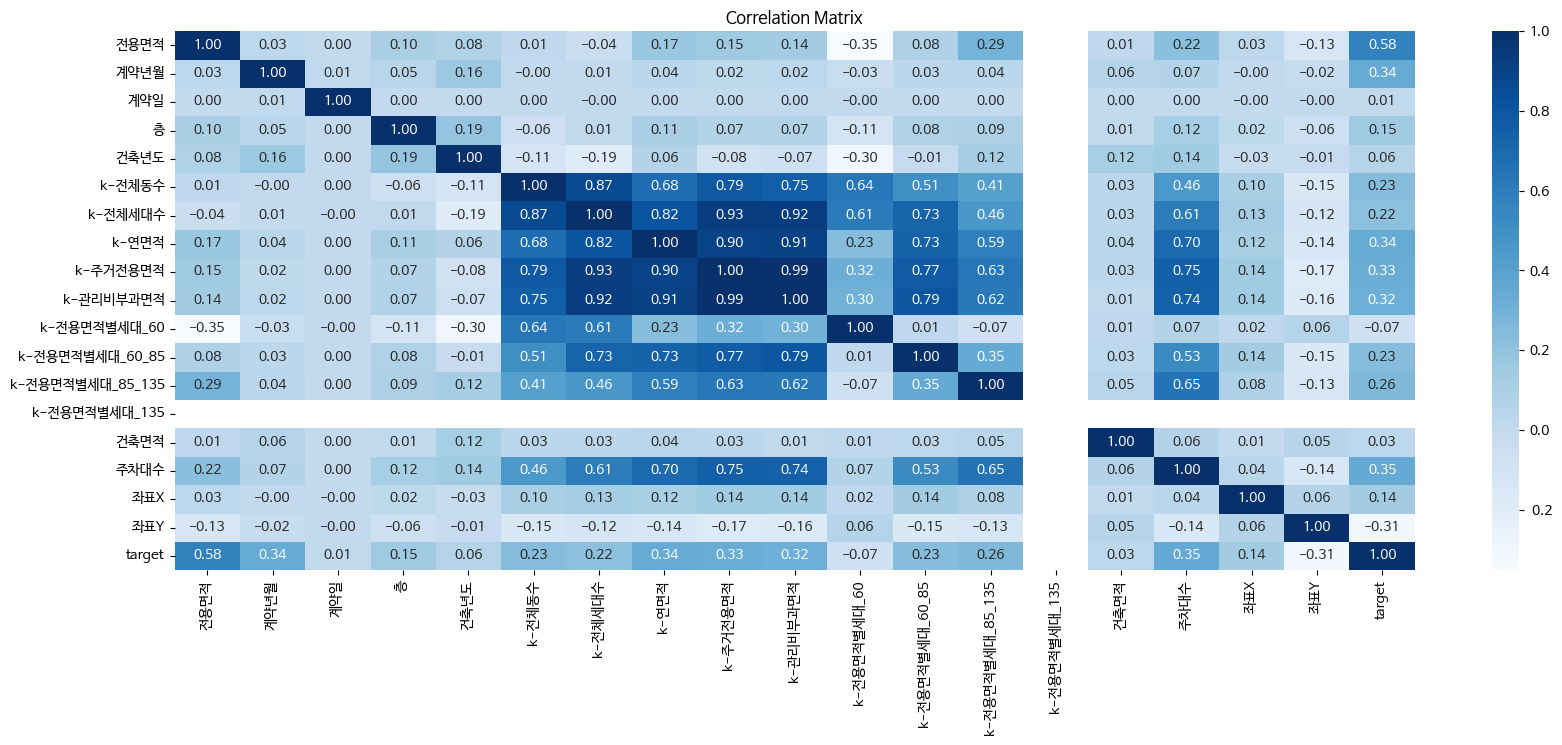

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title('Correlation Matrix')
plt.show()

1. k-전체동수, k-전체세대수, k-연면적, k-주거전용면적, k-관리비부과면적, k-전용면적별세대, 주차대수 간에 높은 상관관계를 보임
    - 아파트 단지 관련 feature들 간에 높은 양의 상관관계
    - 건축면적: 0으로 되어 있는 17399개 결측치를 대체하면 다른 feature들과의 상관계수 달라질 것으로 예상
2. target과의 상관관계가 높은 feature: 전용면적, 주차대수, 계약년월, k-연면적, k-주거전용면적, k-관리비부과면적, 좌표Y
    - 전용면적: 계약된 가구의 전용면적
    - 주차대수: 아파트 단지 전체의 주차 가능 대수
    - 계약년월과 양의 상관관계, 최근일수록 거래가 높음
    - k-연면적: 아파트 단지 전체의 연면적, k-주거전용면적과의 상관계수 0.90
    - k-주거전용면적: 아파트 단지 전체 전용면적 = SUM(전용면적별세대수 x 전용면적)
    - k-관리비부과면적: k-주거전용면적 or k-연면적
    - 좌표Y(위도)와 음의 상관관계, 남쪽으로 갈수록 거래가 높음

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


In [ ]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래의 경우 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(df_concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [ ]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
df_concat['거래유형'] = df_concat['거래유형'].replace('-', np.nan)

# 결측치를 확인해보겠습니다.
df_concat.isnull().sum()

시군구                       0
번지                      227
본번                       75
부번                       75
아파트명                   2136
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
거래유형                1086451
k-단지분류               877273
k-분양형태               876125
k-관리방식               876125
k-복도유형               876454
k-난방방식               876125
k-전체동수               877207
k-전체세대수              876125
k-시공사                877637
k-시행사                877834
k-연면적                876125
k-주거전용면적             876170
k-관리비부과면적            876125
k-전용면적별세대_60         876170
k-전용면적별세대_60_85      876170
k-전용면적별세대_85_135     876170
k-전용면적별세대_135       1127765
경비비관리형태              877561
세대전기계약방법             885389
청소비관리형태              877751
건축면적                 876279
주차대수                 876277
기타/의무/임대/임의          876125
사용허가여부               876125
관리비업로드              

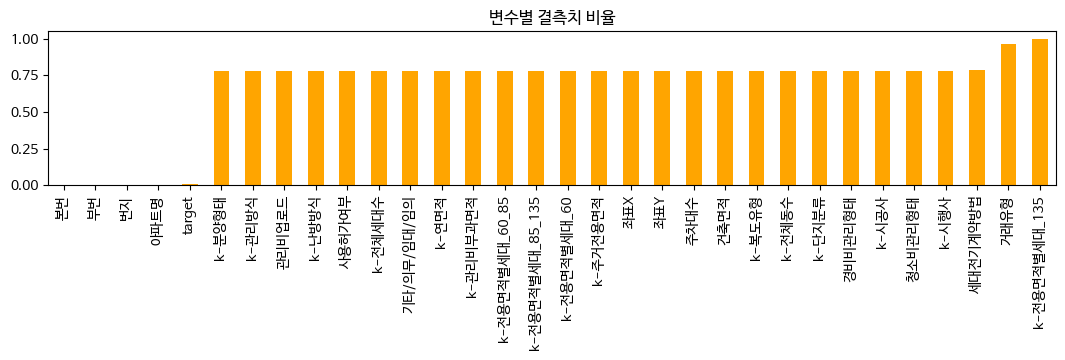

In [ ]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = df_concat.isnull().sum() / df_concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

#### 3.1.1 서울시 공동주택 아파트 정보로 일부 결측치 대체

In [ ]:
# 결측치 대체를 위해 서울시 공동주택 아파트 정보 load(https://data.seoul.go.kr/dataList/OA-15818/A/1/datasetView.do )
apt_path = base_path + 'apartments.csv'
df_apt = pd.read_csv(apt_path, encoding='cp949')

df_apt.shape, df_apt.columns

((2771, 47),
 Index(['번호', 'k-아파트코드', 'k-아파트명', 'k-단지분류(아파트,주상복합등등)', 'kapt도로명주소',
        '주소(시도)k-apt주소split', '주소(시군구)', '주소(읍면동)', '나머지주소', '주소(도로명)',
        '주소(도로상세주소)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', '단지첨부파일',
        'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
        'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적',
        'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
        'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호',
        '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
        '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일'],
       dtype='object'))

In [ ]:
# '도로명주소'을 기준으로 df_train의 결측치 ('아파트명'은 같은 아파트임에도 서로 일치하지 않는 항목이 많아서)
df_apt['도로명주소'] = df_apt['주소(도로명)'] + ' ' + df_apt['주소(도로상세주소)']
df_apt_unique = df_apt.drop_duplicates(subset='도로명주소')

df_concat['좌표X'] = df_concat['좌표X'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['좌표X']))
df_concat['좌표Y'] = df_concat['좌표Y'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['좌표Y']))
df_concat['k-단지분류'] = df_concat['k-단지분류'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['k-단지분류(아파트,주상복합등등)']))
df_concat['k-분양형태'] = df_concat['k-분양형태'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['k-세대타입(분양형태)']))
df_concat['k-관리방식'] = df_concat['k-관리방식'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['k-관리방식']))
df_concat['k-복도유형'] = df_concat['k-복도유형'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['k-복도유형']))
df_concat['k-난방방식'] = df_concat['k-난방방식'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['k-난방방식']))
df_concat['k-시공사'] = df_concat['k-시공사'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['k-건설사(시공사)']))
df_concat['k-시행사'] = df_concat['k-시행사'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['k-시행사']))
df_concat['경비비관리형태'] = df_concat['경비비관리형태'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['경비비관리형태']))
df_concat['세대전기계약방법'] = df_concat['세대전기계약방법'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['세대전기계약방법']))
df_concat['청소비관리형태'] = df_concat['청소비관리형태'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['청소비관리형태']))
df_concat['사용허가여부'] = df_concat['사용허가여부'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['사용허가여부']))
df_concat['관리비업로드'] = df_concat['관리비업로드'].fillna(df_concat['도로명'].map(df_apt_unique.set_index('도로명주소')['청소비관리형태']))
df_concat['청소비관리형태'] = df_concat['청소비관리형태'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['관리비 업로드']))
df_concat['기타/의무/임대/임의'] = df_concat['기타/의무/임대/임의'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['기타/의무/임대/임의=1/2/3/4']))
df_concat['k-전체동수'] = df_concat['k-전체동수'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['k-전체동수']))
df_concat['k-전체세대수'] = df_concat['k-전체세대수'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['k-전체세대수']))
df_concat['k-연면적'] = df_concat['k-연면적'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['k-연면적']))
df_concat['k-주거전용면적'] = df_concat['k-주거전용면적'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['k-주거전용면적']))
df_concat['k-관리비부과면적'] = df_concat['k-관리비부과면적'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['k-관리비부과면적']))
df_concat['k-전용면적별세대_60'] = df_concat['k-전용면적별세대_60'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['k-전용면적별세대현황(60㎡이하)']))
df_concat['k-전용면적별세대_60_85'] = df_concat['k-전용면적별세대_60_85'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['k-전용면적별세대현황(60㎡~85㎡이하)']))
df_concat['k-전용면적별세대_85_135'] = df_concat['k-전용면적별세대_85_135'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['k-85㎡~135㎡이하']))
df_concat['k-전용면적별세대_135'] = df_concat['k-전용면적별세대_135'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['k-135㎡초과']))
df_concat['건축면적'] = df_concat['건축면적'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['건축면적']))
df_concat['주차대수'] = df_concat['주차대수'].fillna(df_concat['아파트명'].map(df_apt_unique.set_index('도로명주소')['주차대수']))

In [ ]:
# df_apt의 데이터로 결측치 대체 후 남은 결측치 확인
df_concat.isnull().sum()

시군구                       0
번지                      227
본번                       75
부번                       75
아파트명                   2136
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
거래유형                1086451
k-단지분류               259137
k-분양형태               257279
k-관리방식               257279
k-복도유형               257608
k-난방방식               256997
k-전체동수               875071
k-전체세대수              873989
k-시공사                260551
k-시행사                261031
k-연면적                873989
k-주거전용면적             874034
k-관리비부과면적            873989
k-전용면적별세대_60         874034
k-전용면적별세대_60_85      874034
k-전용면적별세대_85_135     874034
k-전용면적별세대_135       1127765
경비비관리형태              260240
세대전기계약방법             294467
청소비관리형태              257798
건축면적                 874143
주차대수                 874141
기타/의무/임대/임의          873989
사용허가여부               256686
관리비업로드              

In [ ]:
print("* 결측치가 1개 이상, 50만개 이하안 변수들:", df_concat.columns[(df_concat.isnull().any()) & (df_concat.isnull().sum() < 500000)])
print('* 결측치가 50만개 이상인 변수들 :', df_concat.columns[df_concat.isnull().sum() >= 500000])
print('* 결측치가 100만개 이상인 변수들 :', df_concat.columns[df_concat.isnull().sum() >= 1000000])

* 결측치가 1개 이상, 50만개 이하안 변수들: Index(['번지', '본번', '부번', '아파트명', 'k-단지분류', 'k-분양형태', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-시공사', 'k-시행사', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '사용허가여부',
       '관리비업로드', '좌표X', '좌표Y', 'target'],
      dtype='object')
* 결측치가 50만개 이상인 변수들 : Index(['거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대_60', 'k-전용면적별세대_60_85', 'k-전용면적별세대_85_135', 'k-전용면적별세대_135',
       '건축면적', '주차대수', '기타/의무/임대/임의'],
      dtype='object')
* 결측치가 100만개 이상인 변수들 : Index(['거래유형', 'k-전용면적별세대_135'], dtype='object')


#### 결측치 처리가 필요한 컬럼
   - 범주형
      - '아파트명'
      - '거래유형'
      - 'k-단지분류': ['아파트', '주상복합', nan, '연립주택', '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)']
      - 'k-분양형태': ['분양', '기타', nan, '임대']
      - 'k-관리방식': ['자치관리', '위탁관리', '직영', nan]
      - 'k-복도유형': ['계단식', '혼합식', '복도식', '타워형', '기타', nan]
      - 'k-난방방식': ['개별난방', '지역난방', '기타', nan, '중앙난방']
      - 'k-시공사': (345,)
      - 'k-시행사': (556,)
      - '경비비관리형태': ['직영', '위탁', '위탁+직영', nan, '기타']
      - '세대전기계약방법': ['단일계약', '종합계약', nan]
      - '청소비관리형태': ['직영', '위탁', '위탁+직영', nan, '기타']
      - '사용허가여부': ['Y', nan]
      - '관리비업로드': ['N', nan, 'Y']
      - '기타/의무/임대/임의'
   - 수치형
      - 'k-전체동수'
      - 'k-전체세대수': 전체세대수 / 전체동수 = 1동당 평균세대수 => 파생 변수
      - 'k-연면적'
      - 'k-주거전용면적'
      - 'k-관리비부과면적'
      - 'k-전용면적별세대_60',
      - 'k-전용면적별세대_60_85'
      - 'k-전용면적별세대_85_135',
      - 'k-전용면적별세대_135': 결측치 0으로 대체 가능
      - '건축면적',
      - '주차대수': k-주거전용면적과 상관관계 높음
      - '좌표X', '좌표Y': 좌표계: WGS1984

#### 결측치 처리 방법
- 결측치가 50만개 이상인 변수: '거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대_60', 'k-전용면적별세대_60_85', 'k-전용면적별세대_85_135', 'k-전용면적별세대_135',
       '건축면적', '주차대수', '기타/의무/임대/임의'
    - 결측치 처리 방법? 컬럼 삭제 or 회귀 대체
- 결측치가 50만개 이하인 범주형 변수: 'k-단지분류', 'k-분양형태', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-시공사', 'k-시행사', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '사용허가여부', '관리비업로드'
    - 범주형 변수의 결측치를 채울 방법은? 'NULL'이라는 임의의 범주로 대체
- 결측치가 50만개 이하인 수치형 변수: 좌표X, 좌표Y
    - 결측치를 채울 방법은? 도로명 주소 -> 좌표 변환 api 사용 (https://www.vworld.kr/dev/v4dv_geocoderguide2_s001.do)

#### 3.1.2 결측치가 50만개 이상인 변수 제외


In [ ]:
# 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장
selected = list(df_concat.columns[df_concat.isnull().sum() <= 1000000])
df_concat_select = df_concat[selected]

df_concat.shape, df_concat_select.shape

((1128094, 40), (1128094, 38))

#### 3.1.3 geopy 라이브러리를 이용한 좌표X, 좌표Y 결측치 처리


In [ ]:
!pip install geopy

In [ ]:
# 도로명 주소 좌표 변환 api로 좌표X, 좌표Y 가져오기
from geopy.geocoders import Nominatim
geo_local = Nominatim(user_agent='South Korea')

# 위도, 경도 반환하는 함수
def get_coordinates(addr):
    try:
        geo = geo_local.geocode(addr)
        x, y = geo.longitude, geo.latitude
        return x, y

    except:
        return np.nan, np.nan

# '도로명'이 같은 관측치끼리 한 번만 좌표값을 가져오도록 처리
# unique_roads = df_concat_select[df_concat_select['좌표X'].isnull()]['도로명'].unique()

# for road in tqdm(unique_roads):
#     mask = (df_concat_select['도로명'] == road) & (df_concat_select['좌표X'].isnull())

#     if mask.any():
#         coordinates = get_coordinates(road)

#         # 가져온 좌표값을 결측치가 있는 관측치에 채우기
#         df_concat_select.loc[mask, ['좌표X', '좌표Y']] = coordinates

# df_concat_select.to_csv(base_path + 'df_concat_select.csv', index=False)

In [ ]:
# df_concat_select = pd.read_csv(base_path + 'df_concat_select.csv')

# 좌표X, 좌표Y 결측치 대체 후 남은 결측치 확인
# df_concat_select[['좌표X', '좌표Y']].isnull().sum()

In [ ]:
# 남은 좌표X, 좌표Y 결측치는 지번주소를 사용해 가져오기
df_concat_select['지번주소'] = df_concat_select['시군구'] + ' ' + df_concat_select['본번'].astype('str').str.replace(r'\.0', '')
df_concat_select['지번주소'] += np.where(df_concat_select['부번'].astype('str').str.replace(r'\.0', '') != '0', '-' + df_concat_select['부번'].astype('str').str.replace(r'\.0', ''), '')

# unique_roads = df_concat_select[df_concat_select['좌표X'].isnull()]['지번주소'].unique()

# for road in tqdm(unique_roads):
#     mask = (df_concat_select['지번주소'] == road) & (df_concat_select['좌표X'].isnull())

#     if mask.any():
#         coordinates = get_coordinates(road)

#         # 가져온 좌표값을 결측치가 있는 관측치에 채우기
#         df_concat_select.loc[mask, ['좌표X', '좌표Y']] = coordinates

# df_concat_select.to_csv(base_path + 'df_concat_select.csv', index=False)

In [ ]:
# df_concat_select = pd.read_csv(base_path + 'df_concat_select.csv')

# 좌표X, 좌표Y 결측치 대체 후 남은 결측치 확인
# df_concat_select[['좌표X', '좌표Y']].isnull().sum()

In [ ]:
# df_concat_select[df_concat_select['좌표X'].isnull()]['지번주소'].unique()

# df_concat_select.loc[df_concat_select['지번주소'] == '서울특별시 노원구 상계동 95-274', ['좌표X', '좌표Y']] = 127.077516, 37.664439
# df_concat_select.loc[df_concat_select['지번주소'] == '서울특별시 동대문구 이문동 257-516', ['좌표X', '좌표Y']] = 127.059407, 37.600432

# df_concat_select[['좌표X', '좌표Y']].to_csv(base_path + 'coordinates.csv'', index=False)

# # 좌표X, 좌표Y 결측치 대체 후 남은 결측치 확인
# df_concat_select[['좌표X', '좌표Y']].isnull().sum()

In [ ]:
# 서울시 공동주택 데이터 및 geopy 라이브러리를 사용한 결측치 대체 완료 후 좌표 데이터 불러오기
df_coordinates = pd.read_csv(base_path + 'coordinates.csv')
df_concat_select[['좌표X', '좌표Y']] = df_coordinates[['좌표X', '좌표Y']]

#### 3.1.4 남은 결측치 보간

In [ ]:
# 지번주소 컬럼 생성으로 필요 없어진 컬럼 삭제
df_concat_select = df_concat_select.drop(['번지', '본번', '부번'], axis=1)

# df_concat_select에서 수치형 변수와 범주형 변수 분리
numerical_cols = df_concat_select.select_dtypes(include=['number']).columns.difference(['target', 'is_test'])
categorical_cols = df_concat_select.select_dtypes(include=['object']).columns

print("수치형 변수:", numerical_cols)
print("범주형 변수:", categorical_cols)

수치형 변수: Index(['k-관리비부과면적', 'k-연면적', 'k-전용면적별세대_60', 'k-전용면적별세대_60_85',
       'k-전용면적별세대_85_135', 'k-전체동수', 'k-전체세대수', 'k-주거전용면적', '건축년도', '건축면적',
       '계약년월', '계약일', '전용면적', '좌표X', '좌표Y', '주차대수', '층'],
      dtype='object')
범주형 변수: Index(['시군구', '아파트명', '도로명', 'k-단지분류', 'k-분양형태', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-시공사', 'k-시행사', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의',
       '사용허가여부', '관리비업로드', '지번주소'],
      dtype='object')


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [ ]:
# 결측치가 존재하는 컬럼
cols_with_missing_vals = df_concat_select.columns[df_concat_select.isnull().any()]
missing_vals_cnt = df_concat_select.isnull().sum()[cols_with_missing_vals]

print('결측치가 존재하는 수치형 변수:')
print(missing_vals_cnt[cols_with_missing_vals.isin(numerical_cols)])
print('결측치가 존재하는 범주형 변수:')
print(missing_vals_cnt[cols_with_missing_vals.isin(categorical_cols)])

결측치가 존재하는 수치형 변수:
k-전체동수              875071
k-전체세대수             873989
k-연면적               873989
k-주거전용면적            874034
k-관리비부과면적           873989
k-전용면적별세대_60        874034
k-전용면적별세대_60_85     874034
k-전용면적별세대_85_135    874034
건축면적                874143
주차대수                874141
dtype: int64
결측치가 존재하는 범주형 변수:
아파트명             2136
k-단지분류         259137
k-분양형태         257279
k-관리방식         257279
k-복도유형         257608
k-난방방식         256997
k-시공사          260551
k-시행사          261031
경비비관리형태        260240
세대전기계약방법       294467
청소비관리형태        257798
기타/의무/임대/임의    873989
사용허가여부         256686
관리비업로드         258306
dtype: int64


##### 3.1.4.1 회귀 모델에 기반한 수치형 변수 대체

In [ ]:
df_concat_select = df_concat_select.reset_index()

# 수치형 변수에 대한 보간 (회귀 보간)
num_cols_with_missing_vals = cols_with_missing_vals[cols_with_missing_vals.isin(numerical_cols)]

for col in tqdm(num_cols_with_missing_vals):
    reg_train = df_concat_select[df_concat_select[col].notnull()].drop(['target', 'is_test'], axis=1)
    reg_test = df_concat_select[df_concat_select[col].isnull()].drop(['target', 'is_test'], axis=1)
    X_cols = reg_train.columns[(reg_train.isnull().sum() == 0) & (reg_test.isnull().sum() == 0)].tolist()

    X_reg_train = reg_train[X_cols]
    y_reg_train = reg_train[col]
    X_reg_test = reg_test[X_cols]

    # Label-Encoding
    cat_cols = X_reg_train.select_dtypes(include=['object']).columns
    label_encoders = {}
    for cat_col in cat_cols:
        lbl = LabelEncoder()

        lbl.fit(X_reg_train[cat_col].astype(str))
        X_reg_train[cat_col] = lbl.transform(X_reg_train[cat_col].astype(str))
        label_encoders[cat_col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

        for label in np.unique(X_reg_test[cat_col].astype(str)):
            if label not in lbl.classes_:
                lbl.classes_ = np.append(lbl.classes_, label)
        X_reg_test[cat_col] = lbl.transform(X_reg_test[cat_col].astype(str))

    # RandomForestRegressor를 이용해 분류 모델로 학습
    model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
    model.fit(X_reg_train, y_reg_train)
    pred = model.predict(X_reg_test)

    df_concat_select.loc[reg_test.index, col] = pred

# 수치형 변수의 결측치가 보간된 모습 확인
df_concat_select.isnull().sum()

100%|██████████| 10/10 [01:01<00:00,  6.17s/it]


index                    0
시군구                      0
아파트명                  2136
전용면적                     0
계약년월                     0
계약일                      0
층                        0
건축년도                     0
도로명                      0
k-단지분류              259137
k-분양형태              257279
k-관리방식              257279
k-복도유형              257608
k-난방방식              256997
k-전체동수                   0
k-전체세대수                  0
k-시공사               260551
k-시행사               261031
k-연면적                    0
k-주거전용면적                 0
k-관리비부과면적                0
k-전용면적별세대_60             0
k-전용면적별세대_60_85          0
k-전용면적별세대_85_135         0
경비비관리형태             260240
세대전기계약방법            294467
청소비관리형태             257798
건축면적                     0
주차대수                     0
기타/의무/임대/임의         873989
사용허가여부              256686
관리비업로드              258306
좌표X                      0
좌표Y                      0
target                9272
is_test                  0
지번주소                     0
d

##### 3.1.4.2 분류 모델에 기반한 범주형 변수 대체

In [ ]:
# 범주형 변수에 대한 보간
cat_cols_with_missing_vals = cols_with_missing_vals[cols_with_missing_vals.isin(categorical_cols)]

for col in tqdm(cat_cols_with_missing_vals):
    clf_train = df_concat_select[df_concat_select[col].notnull()].drop(['target', 'is_test'], axis=1)
    clf_test = df_concat_select[df_concat_select[col].isnull()].drop(['target', 'is_test'], axis=1)
    X_cols = clf_train.columns[(clf_train.isnull().sum() == 0) & (clf_test.isnull().sum() == 0)].tolist()

    X_clf_train = clf_train[X_cols]
    y_clf_train = clf_train[col]
    X_clf_test = clf_test[X_cols]

    # Label-Encoding
    cat_cols = X_clf_train.select_dtypes(include=['object']).columns
    label_encoders = {}
    for cat_col in cat_cols:
        lbl = LabelEncoder()

        lbl.fit(X_clf_train[cat_col].astype(str))
        X_clf_train[cat_col] = lbl.transform(X_clf_train[cat_col].astype(str))
        label_encoders[cat_col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

        for label in np.unique(X_clf_test[cat_col].astype(str)):
            if label not in lbl.classes_:
                lbl.classes_ = np.append(lbl.classes_, label)
        X_clf_test[cat_col] = lbl.transform(X_clf_test[cat_col].astype(str))

    # RandomForestClassifier를 이용해 회귀 모델로 학습
    model = RandomForestClassifier(n_estimators=5, random_state=1, n_jobs=-1)
    model.fit(X_clf_train, y_clf_train)
    pred = model.predict(X_clf_test)

    df_concat_select.loc[clf_test.index, col] = pred

# 범주형 변수의 결측치가 보간된 모습 확인
df_concat_select.isnull().sum()

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [02:49<00:00, 12.11s/it]


index                  0
시군구                    0
아파트명                   0
전용면적                   0
계약년월                   0
계약일                    0
층                      0
건축년도                   0
도로명                    0
k-단지분류                 0
k-분양형태                 0
k-관리방식                 0
k-복도유형                 0
k-난방방식                 0
k-전체동수                 0
k-전체세대수                0
k-시공사                  0
k-시행사                  0
k-연면적                  0
k-주거전용면적               0
k-관리비부과면적              0
k-전용면적별세대_60           0
k-전용면적별세대_60_85        0
k-전용면적별세대_85_135       0
경비비관리형태                0
세대전기계약방법               0
청소비관리형태                0
건축면적                   0
주차대수                   0
기타/의무/임대/임의            0
사용허가여부                 0
관리비업로드                 0
좌표X                    0
좌표Y                    0
target              9272
is_test                0
지번주소                   0
dtype: int64